# Hands-on Machine Learning
# Exercise 3-3: Titanic Dataset

## Setup

In [3]:
# Is Python version at least 3.5?
import sys
assert sys.version_info >= (3, 5)

In [4]:
# Is sklearn version at least 0.2?
import sklearn
assert sklearn.__version__ >= "0.20"

In [5]:
# Helper libraries
import numpy as np
import pandas as pd 

In [7]:
# Matplotlib setup
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Importing Data
Assumes `train.csv` and `test.csv` for the Titanic dataset from Kaggle have been placed in the same directoy as this notebook.

In [8]:
import os

In [15]:
TITANIC_PATH = os.path.join(os.getcwd(), 'titanic-data')

In [16]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    """Loads a CSV file from the specified directory into a dataframe"""
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [17]:
# Use the function to read in train and test data
train_data = load_titanic_data('train.csv')
test_data = load_titanic_data('test.csv')

## Exploratory Data Analysis

Examining the training and test set shapes.

In [19]:
print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

Training set shape: (891, 12)
Test set shape: (418, 11)


Training data has one column that the test set does not. Let's examine to find out what it is.

In [23]:
list(train_data.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [22]:
list(test_data.columns)

['PassengerId',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

The test data does not have a `Survived` column. This is the target column - given a passenger's class, name, age, sex, number of siblings on board and other features, we want to predict whether the passenger survived the titanic crash.

This is common in Kaggle competitions. We won't have labels for the test set.

In [24]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


What do the attributes mean?
- `Survived`: target. 0 means that the passenger did not survive. 1 means that the passenger survived.
- `Pclass`: passenger class (1 being first class, 3 being 3rd class. 1st class passengers were closer to decks?)
- `Name`, `Sex`, `Age`: self-explanatory.
- `SibSp`: Number of the passenger's siblings or spouses on board.
- `Parch`: How many parents or children the passenger had on board the Titanic.
- `Ticket`: Ticket ID
- `Fare`: price paid in GBP
- `Cabin`: Passenger's cabin number
- `Embarked`: Where the passenger embarked the Titanic.

Examining how much data is missing.

In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are 891 training examples in the training set. However, not all of them have values for all attributes.
- No missing data for `PassengerID`, `Pclass`, `Name`, `Sex`, `SibSp`, `Parch`, `Ticket`, `Fare`.
- Lots of missing values for the `Cabin` attribute.
- 2 missing values for `Embarked`. 
- ~100 missing values in the `Age` column.

Since close to 77% of the values in the `Cabin` column are missing, it's safe to drop this. `Age` has 19% null values - can replace them with median age using `sklearn`'s imputer.

`Name` and `Ticket` will require significant feature engineering to use. 

In [27]:
# Examining statistics for numeric attributes
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### What does this tell us?
- Mean age of passengers was around 30 years.
- Mean value of the `Survived` column is 38%. Since this is a binary numeric attribute, this means that of all the passengers in the training set, only 38% survived. 
- We can use this as a baseline accuracy to try and beat.

In [29]:
# Using `value_counts` to confirm the target is binary
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [30]:
# Doing the same for all other categorical attributes
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [31]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [32]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Building a Data Preprocessing Pipeline

The data preprocessing pipeline will begin with a custom transformer class that extends the `TransformerMixin` and `BaseEstimator` classes.

Extending the first class allows us to 
- define our own custom data transformation rules for the dataset. 
- Gain access to the `fit` and `transform` as well as `fit_transform` methods that will modify the data and extract specific features according to our rules.

By extending the `BaseEstimator` class, we gain access to the `get_params()` and `set_params()` functions, which can be useful for hyperparameter tuning.

This preprocessing transformer will be initialized with a list of column names/attribute names which it will then use to extract these attributes from the dataset.

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

In [37]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """Custom transformer class that extracts a specified list of parameters from a dataset."""
    def __init__(self, attribute_names):
        """Select list of attributes to extract from the dataset"""
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        # Nothing left to do
        return self
    def transform(self, X):
        """Extract the specified attributes"""
        return X[self.attribute_names]

In [38]:
# Data processing pipeline
from sklearn.pipeline import Pipeline

# Imputer will be used to fill in missing values for `age` with the median age
from sklearn.impute import SimpleImputer

Instantiate a numerical transformation pipeline that will replace all missing values for the specified numeric columns with their median values.

In [39]:
num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(['Age', 'SibSp', 'Parch', 'Fare'])),
    ('imputer', SimpleImputer(strategy='median'))
])

In [40]:
# Transform the numeric columns
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

Now instantiating a second transformer class that will be used to encode categorical attributes and also replace any missing values with the most frequently occurring value for that attribute. 

In [41]:
from sklearn.preprocessing import OneHotEncoder

In [55]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    """Replaces missing categorical attribute values with most 
    frequently occurring value for that attribute"""
    def fit(self, X, y=None):
        """Creates new instance variable that is a Series with 
        the most frequently occurring value for each column"""
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        """Replaces missing values using Series"""
        return X.fillna(self.most_frequent_);

Instantiating a categorical feature pipeline that does three things
1. Uses the `DataFrameSelector` transformer we defined earlier to extract all categorical features from the dataset using a list of column names.
2. Uses a second transformer - the `MostFrequentImputer` - to replace missing values for each attribute with the most frequently occurring value.
3. Once missing values have been filled in, uses `sklearn`'s `OneHotEncoder` to transform the categorical features into one-hot encoded vectors.

In [56]:
cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imputer', MostFrequentImputer()), 
    ('cat_encoder', OneHotEncoder(sparse=False))
])

In [57]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Now combine the two pipelines (numerical AND categorical) into a single pipleine that preprocesses both categorical and numeric features and combines them into a single dataset.

In [58]:
from sklearn.pipeline import FeatureUnion

In [60]:
preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline), 
    ('cat_pipeline', cat_pipeline)
])

## Storing preprocessed data

In [61]:
X_train = preprocess_pipeline.fit_transform(train_data)

In [62]:
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [64]:
# Extracting labels
y_train = train_data['Survived']

## Model 1 - Support Vector Classifier

In [65]:
from sklearn.svm import SVC

In [66]:
# Instantiate
svm_clf = SVC(gamma='auto')

# Train
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [67]:
# Making predictions
X_test = preprocess_pipeline.transform(test_data)

In [68]:
y_pred = svm_clf.predict(X_test)

### Cross Validating Model

In [69]:
from sklearn.model_selection import cross_val_score

In [70]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)

In [71]:
# What is the mean accuracy across all 10 folds
svm_scores.mean()

0.7365250822835092

Achieved 73.6% accuracy which is much better than random chance/baseline accuracy of 38%. But can we do better?

## Model 2 - Random Forest Classifier

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
# This can take a while
forest_clf = RandomForestClassifier(n_estimators=100, 
                                   random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)

In [76]:
forest_scores.mean()

0.8149526160481217

The cross-valiated training set score is 81.5%, which is much better than the Support Vector Classifier's score. 

## Visualizing Outliers and Interquartile Range
A better visualization of the cross-validation scores is to plot the interquartile range of cross validation scores instead of just printing the mean value.

This helps identify outliers: any values that are greater or less than the maximum or minimum values respectively by 1.5 times the IQR.

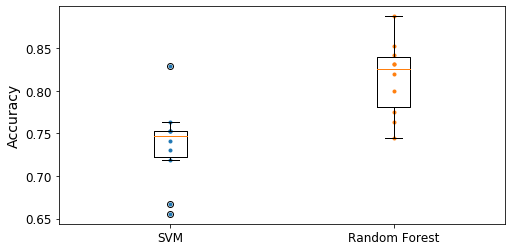

In [77]:
plt.figure(figsize=(8, 4))
plt.plot([1] * 10, svm_scores, '.')
plt.plot([2] * 10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))
plt.ylabel('Accuracy', fontsize=14)
plt.show()